In [1]:
import os
import torch
import yaml
from pathlib import Path
import random
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import plotly.graph_objects as go
from torch.utils.data import Dataset

from nerfstudio.configs import base_config as cfg
from nerfstudio.configs.method_configs import method_configs
from nerfstudio.data.dataparsers.nerfosr_dataparser import NeRFOSR, NeRFOSRDataParserConfig
from nerfstudio.pipelines.base_pipeline import VanillaDataManager
from nerfstudio.field_components.field_heads import FieldHeadNames
from nerfstudio.cameras.rays import RayBundle, RaySamples, Frustums
from nerfstudio.utils.colormaps import apply_depth_colormap
from nerfstudio.field_components.encodings import SHEncoding, NeRFEncoding
import tinycudann as tcnn

from reni_neus.models.reni_neus_model import RENINeuSFactoModelConfig, RENINeuSFactoModel
from reni_neus.utils.utils import look_at_target, random_points_on_unit_sphere
from reni_neus.data.datamanagers.reni_neus_datamanager import RENINeuSDataManagerConfig, RENINeuSDataManager
from reni_neus.configs.ddf_config import DirectionalDistanceField
from reni_neus.configs.reni_neus_config import RENINeuS
from reni_neus.utils.utils import find_nerfstudio_project_root, rot_z
from reni.illumination_fields.sh_illumination_field import SphericalHarmonicIlluminationFieldConfig, SphericalHarmonicIlluminationField, get_spherical_harmonic_representation, getCoefficientsFromImage, shReconstructSignal

project_root = find_nerfstudio_project_root(Path(os.getcwd()))
# set current working directory to nerfstudio project root
os.chdir(project_root)

# setup config
test_mode = 'test'
world_size = 1
local_rank = 0
device = 'cuda:0'

reni_neus_config = RENINeuS
reni_neus_config.config.pipeline.model.use_visibility = True
reni_neus_config.config.pipeline.model.visibility_threshold = 0.1
reni_neus_config.config.pipeline.model.fit_visibility_field = False


pipeline = reni_neus_config.config.pipeline.setup(device=device, test_mode=test_mode, world_size=world_size, local_rank=local_rank)
datamanager = pipeline.datamanager
model = pipeline.model
model = model.eval()

Setting up training dataset...

Caching all 160 images.

Output()

Setting up evaluation dataset...

Caching all 95 images.

Output()

Caching all 95 images.

Output()

Caching all 95 images.

Output()

/tmp/ipykernel_13960/329409560.py:5: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(img).float() / 255


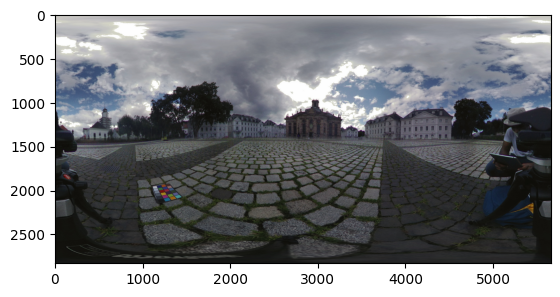

In [2]:
# load image
img_path = '/workspace/data/NeRF-OSR/Data/lk2/final/ENV_MAP_CC/08-08_16_00/20210808_164134.jpg'
img = plt.imread(img_path)
# convert to torch float tensor in range 0 to 1
img = torch.from_numpy(img).float() / 255
plt.imshow(img)

In [18]:
import os
import matplotlib.pyplot as plt
import torch
import pyexr
from torchvision.transforms import Resize
from torchvision.transforms.functional import to_tensor

# Define the folder path
folder_path = '/workspace/data/NeRF-OSR/Data/envmaps/site2'
target_height = 64
target_width = 128

# Resize transformation
resize_transform = Resize([target_height, target_width])

# Iterate over each file in the folder
for file_name in os.listdir(folder_path):
    # Check if the file is an image
    if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        img_path = os.path.join(folder_path, file_name)

        # Read the image
        img = to_tensor(plt.imread(img_path))

        # Resize the image
        img = resize_transform(img)

        # Modify pixel values
        img[img > 0.95] *= 10
        
        # C, H, W -> H, W, C
        img = img.permute(1, 2, 0)
        # Save as .exr
        # Convert tensor to numpy array and reshape if necessary
        img_exr = img.numpy()
        exr_path = os.path.join(folder_path, os.path.splitext(file_name)[0] + '.exr')
        pyexr.write(exr_path, img_exr)


/home/user/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
/home/user/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current def

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import yaml
import re
from typing import Optional
from nerfstudio.cameras.rays import RaySamples, Frustums
from nerfstudio.cameras.cameras import Cameras, CameraType

from reni.configs.reni_config import RENIField
from reni.configs.sh_sg_envmap_configs import SHField, SGField
from reni.pipelines.reni_pipeline import RENIPipeline
from reni.field_components.field_heads import RENIFieldHeadNames
from reni.data.datamanagers.reni_datamanager import RENIDataManager
from reni.utils.utils import find_nerfstudio_project_root, rot_z, rot_y
from reni.utils.colourspace import linear_to_sRGB

# setup config
test_mode = 'test'
world_size = 1
local_rank = 0
device = 'cuda:0'

project_root = find_nerfstudio_project_root(Path(os.getcwd()))
# set current working directory to nerfstudio project root
os.chdir(project_root)

def load_model(load_dir: Path, load_step: Optional[int] = None):
    ckpt_dir = load_dir / 'nerfstudio_models'
    def clean_and_load_yaml(yaml_content):
        # Remove !!python related tags
        cleaned_content = re.sub(r'!!python[^\s]*', '', yaml_content)
        
        # Load the cleaned content
        return yaml.safe_load(cleaned_content)

    if load_step is None:
        load_step = sorted(int(x[x.find("-") + 1 : x.find(".")]) for x in os.listdir(ckpt_dir))[-1]
    
    ckpt = torch.load(ckpt_dir / f'step-{load_step:09d}.ckpt', map_location=device)
    reni_model_dict = {}
    for key in ckpt['pipeline'].keys():
        if key.startswith('_model.'):
            reni_model_dict[key[7:]] = ckpt['pipeline'][key]
    
    config_path = load_dir / 'config.yml'
    with open(config_path, 'r') as f:
        content = f.read()
        config = clean_and_load_yaml(content)
    
    if 'latent_dim' in config['pipeline']['model']['field'].keys():
        
        model_config = RENIField.config
        model_config.pipeline.datamanager.dataparser.convert_to_ldr = config['pipeline']['datamanager']['dataparser']['convert_to_ldr']
        model_config.pipeline.datamanager.dataparser.convert_to_log_domain = config['pipeline']['datamanager']['dataparser']['convert_to_log_domain']
        if config['pipeline']['datamanager']['dataparser']['eval_mask_path'] is not None:
            eval_mask_path = Path(os.path.join(*config['pipeline']['datamanager']['dataparser']['eval_mask_path']))
            model_config.pipeline.datamanager.dataparser.eval_mask_path = eval_mask_path
        else:
            model_config.pipeline.datamanager.dataparser.eval_mask_path = None
        if config['pipeline']['datamanager']['dataparser']['min_max_normalize'].__class__ == list:
            model_config.pipeline.datamanager.dataparser.min_max_normalize = tuple(config['pipeline']['datamanager']['dataparser']['min_max_normalize'])
        else:
            model_config.pipeline.datamanager.dataparser.min_max_normalize = config['pipeline']['datamanager']['dataparser']['min_max_normalize']
        model_config.pipeline.datamanager.dataparser.augment_with_mirror = config['pipeline']['datamanager']['dataparser']['augment_with_mirror']
        model_config.pipeline.model.loss_inclusions = config['pipeline']['model']['loss_inclusions']
        model_config.pipeline.model.field.conditioning = config['pipeline']['model']['field']['conditioning']
        model_config.pipeline.model.field.invariant_function = config['pipeline']['model']['field']['invariant_function']
        model_config.pipeline.model.field.equivariance = config['pipeline']['model']['field']['equivariance']
        model_config.pipeline.model.field.axis_of_invariance = config['pipeline']['model']['field']['axis_of_invariance']
        model_config.pipeline.model.field.positional_encoding = config['pipeline']['model']['field']['positional_encoding']
        model_config.pipeline.model.field.encoded_input = config['pipeline']['model']['field']['encoded_input']
        model_config.pipeline.model.field.latent_dim = config['pipeline']['model']['field']['latent_dim']
        model_config.pipeline.model.field.hidden_features = config['pipeline']['model']['field']['hidden_features']
        model_config.pipeline.model.field.hidden_layers = config['pipeline']['model']['field']['hidden_layers']
        model_config.pipeline.model.field.mapping_layers = config['pipeline']['model']['field']['mapping_layers']
        model_config.pipeline.model.field.mapping_features = config['pipeline']['model']['field']['mapping_features']
        model_config.pipeline.model.field.num_attention_heads = config['pipeline']['model']['field']['num_attention_heads']
        model_config.pipeline.model.field.num_attention_layers = config['pipeline']['model']['field']['num_attention_layers']
        model_config.pipeline.model.field.output_activation = config['pipeline']['model']['field']['output_activation']
        model_config.pipeline.model.field.last_layer_linear = config['pipeline']['model']['field']['last_layer_linear']
        model_config.pipeline.model.field.trainable_scale = config['pipeline']['model']['field']['trainable_scale']
        model_config.pipeline.model.field.old_implementation = config['pipeline']['model']['field']['old_implementation']
        model_config.pipeline.model.loss_inclusions = config['pipeline']['model']['loss_inclusions']
    elif 'spherical_harmonic_order' in config['pipeline']['model']['field'].keys():
        model_config = SHField.config
        model_config.pipeline.model.field.spherical_harmonic_order = config['pipeline']['model']['field']['spherical_harmonic_order']
    elif 'row_col_gaussian_dims' in config['pipeline']['model']['field'].keys():
        model_config = SGField.config
        model_config.pipeline.model.field.row_col_gaussian_dims = config['pipeline']['model']['field']['row_col_gaussian_dims']

    model_config.pipeline.datamanager.dataparser.apply_eval_rotation = False
    
    model_config.pipeline.datamanager.dataparser.custom_val_folder = 'osr_envmaps'

    pipeline: RENIPipeline = model_config.pipeline.setup(
      device=device,
      test_mode=test_mode,
      world_size=world_size,
      local_rank=local_rank,
      grad_scaler=None,
    )

    datamanager = pipeline.datamanager

    model = pipeline.model

    model.to(device)
    # remove 'field.eval_mu' and field.eval_logvar' from state dict
    reni_model_dict.pop('field.eval_mu')
    reni_model_dict.pop('field.eval_logvar')
    model.load_state_dict(reni_model_dict, strict=False)
    model.eval()

    return pipeline, datamanager, model

model_path = '/workspace/outputs/reni/reni_plus_plus_models/latent_dim_100'
pipeline, datamanager, model = load_model(Path(model_path))
model.fit_eval_latents(datamanager)

Setting up training dataset...

Caching all 3346 images.

Warning: If you run out of memory, try reducing the number of images to sample from.

Output()

In [15]:
model.field.eval_mu.shape
# save data at .pt at /workspace/data/NeRF-OSR/Data/envmaps/site3/reni_latents.pt
torch.save(model.field.eval_mu, '/workspace/data/NeRF-OSR/Data/envmaps/site2/reni_latents.pt')

In [2]:
image_idx, ray_bundle, batch = pipeline.datamanager.next_eval_image(0)
outputs = pipeline.model(ray_bundle, batch)

/home/user/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


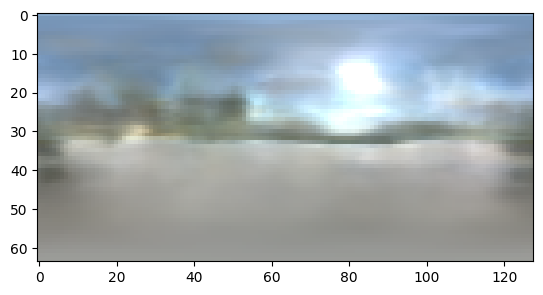

In [13]:
unnormalised_img = model.field.unnormalise(outputs['rgb'])

plt.imshow(linear_to_sRGB(unnormalised_img, use_quantile=True).reshape(64, 128, 3).cpu().detach().numpy())
# plt.imshow(outputs['rgb'].reshape(64, 128, 3).cpu().detach().numpy())

In [17]:
rotations = rot_z(torch.tensor(np.linspace(0, 2 * np.pi, 5)))

ValueError: only one element tensors can be converted to Python scalars

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


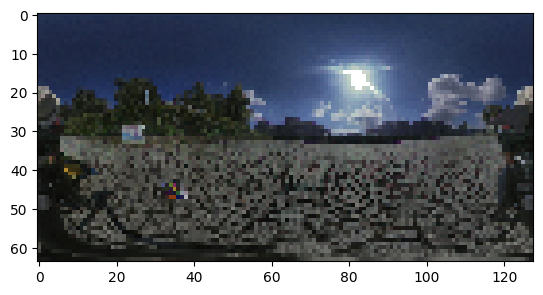

In [11]:
import pyexr
img_path = '/workspace/data/RENI_HDR/osr_envmaps/01-09_14_00.exr'
img = pyexr.read(img_path)
img = torch.from_numpy(img).float()
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


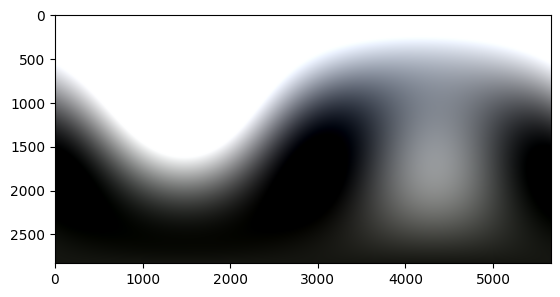

In [19]:
# As per NeRF-OSR 'then we multiply regions with value>0.95 by a factor of 10 to account for the overexposed sun"
img_path = '/workspace/data/NeRF-OSR/Data/lk2/final/ENV_MAP_CC/08-08_16_00/20210808_164134.jpg'
img = plt.imread(img_path)
# convert to torch float tensor in range 0 to 1
img = torch.from_numpy(img).float() / 255
img[img > 0.95] *= 10
# img = img*5
# roll the columns of the image by N pixels
N = 4000
img = torch.roll(img, N, 1)
x = get_spherical_harmonic_representation(img, 2)
plt.imshow(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


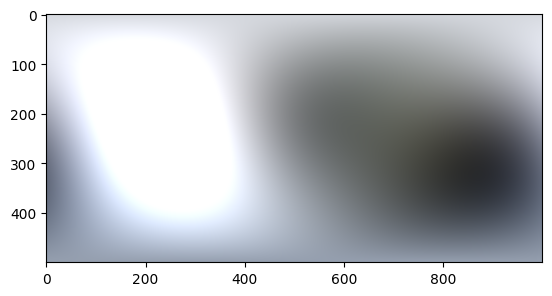

In [16]:
coeffs_path = '/workspace/data/NeRF-OSR/Data/lk2/final/envmaps/08-08_16_00.txt'
orig_coeffs = np.loadtxt(coeffs_path)
orig_coeffs = torch.from_numpy(orig_coeffs).float()
radianceimage = shReconstructSignal(orig_coeffs * 2, 1000, 'cpu')
# invert y axis
radianceimage = radianceimage.flip(0)
plt.imshow(radianceimage)

In [9]:
coeffs = getCoefficientsFromImage(img, 2)

In [10]:
coeffs.shape

torch.Size([9, 3])

Get the coeffs provided in the dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


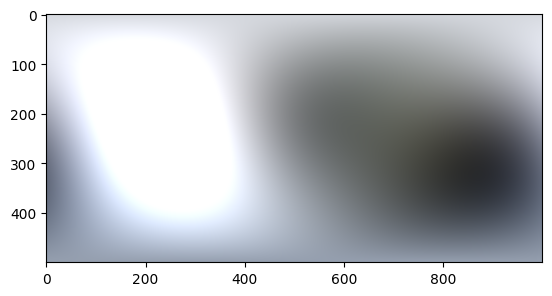

In [5]:
coeffs_path = '/workspace/data/NeRF-OSR/Data/lk2/final/envmaps/08-08_16_00.txt'
orig_coeffs = np.loadtxt(coeffs_path)
orig_coeffs = torch.from_numpy(orig_coeffs).float()
radianceimage = shReconstructSignal(orig_coeffs * 2, 1000, 'cpu')
# invert y axis
radianceimage = radianceimage.flip(0)
plt.imshow(radianceimage)

In [13]:
orig_coeffs, coeffs

(array([[ 1.20642638e+00,  1.23752332e+00,  1.29474914e+00],
        [-5.16301930e-01, -5.24835587e-01, -5.73830128e-01],
        [-1.27323002e-01, -1.13433748e-01, -9.37819928e-02],
        [ 8.74511956e-04, -2.44023558e-03, -2.69883629e-02],
        [ 5.01060709e-02,  5.88870458e-02,  6.56442642e-02],
        [-3.63264382e-02, -4.56135646e-02, -5.19036166e-02],
        [ 2.28986554e-02,  2.92217005e-02,  3.77669781e-02],
        [ 1.20350003e-01,  1.19136885e-01,  1.20814413e-01],
        [-1.47541285e-01, -1.46637619e-01, -1.37164354e-01]]),
 tensor([[1.9908, 2.0247, 2.0772],
         [0.1847, 0.1852, 0.2045],
         [1.2813, 1.2969, 1.3582],
         [0.7994, 0.7843, 0.7584],
         [0.5575, 0.5575, 0.5567],
         [0.1994, 0.2072, 0.2134],
         [0.2314, 0.2338, 0.2281],
         [0.7075, 0.6942, 0.6807],
         [0.6375, 0.6426, 0.6424]]))

In [7]:
config = SphericalHarmonicIlluminationFieldConfig()
sh_field = config.setup(num_train_data=1, num_eval_data=1, normalisations=None)